In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn.metrics import accuracy_score

In [25]:
# Load the dataset
mat = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines.mat')
mat_gt = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines_gt.mat')

data = mat['indian_pines']
labels = mat_gt['indian_pines_gt']

In [41]:
# Reshape the data to (num_samples, num_features)
n, m, num_samples = data.shape
data_reshaped = np.reshape(data, (n*m, num_samples))
labels_reshaped = np.reshape(labels, (n*m,))

# Apply LDA to reduce the dimensionality of the data
num_components = 16
lda = LDA(n_components=num_components)
data_lda = lda.fit_transform(data_reshaped, labels.ravel())

from keras.models import Sequential
from keras.layers import Dense, Conv1D

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=data_lda.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(17, activation='softmax'))

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoding
num_labels = len(np.unique(labels_reshaped))
labels_onehot = np.eye(num_labels)[labels_reshaped.reshape(-1)]

# print(labels_onehot)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_lda, labels_onehot, test_size=0.3, random_state=42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)
# Train the neural network on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the neural network on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

Epoch 1/50
368/368 [==============================] - 5s 7ms/step - loss: 1.1666 - accuracy: 0.6438 - val_loss: 0.7545 - val_accuracy: 0.7255
Epoch 2/50
368/368 [==============================] - 2s 6ms/step - loss: 0.6912 - accuracy: 0.7445 - val_loss: 0.6616 - val_accuracy: 0.7497
Epoch 3/50
368/368 [==============================] - 2s 6ms/step - loss: 0.6353 - accuracy: 0.7622 - val_loss: 0.6332 - val_accuracy: 0.7571
Epoch 4/50
368/368 [==============================] - 2s 6ms/step - loss: 0.6088 - accuracy: 0.7701 - val_loss: 0.6103 - val_accuracy: 0.7677
Epoch 5/50
368/368 [==============================] - 2s 6ms/step - loss: 0.5907 - accuracy: 0.7751 - val_loss: 0.5989 - val_accuracy: 0.7697
Epoch 6/50
368/368 [==============================] - 2s 6ms/step - loss: 0.5760 - accuracy: 0.7790 - val_loss: 0.5822 - val_accuracy: 0.7721
Epoch 7/50
368/368 [==============================] - 2s 6ms/step - loss: 0.5636 - accuracy: 0.7836 - val_loss: 0.5944 - val_accuracy: 0.7694
Epoch 

658/658 [==============================] - 3s 4ms/step
Clustered labels accuracy: 0.8175029726516052


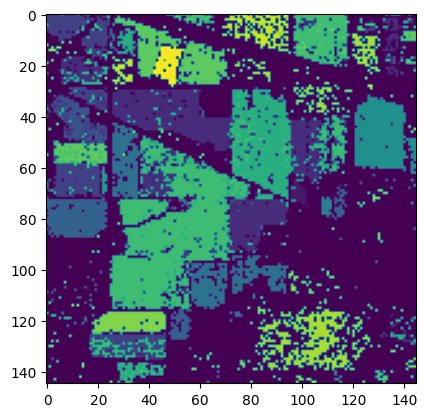

In [70]:
# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_lda)
# smoothed_preds = np.apply_along_axis(lambda x: np.convolve(x, [1/3, 1/3, 1/3], mode='same'), axis=1, arr=cluster_labels_onehot)
cluster_labels = np.argmax(cluster_labels_onehot, axis=1)

cluster_labels_reshaped = np.reshape(cluster_labels, (n, m))
accuracy = np.mean(cluster_labels_reshaped == labels)
print("Clustered labels accuracy:", accuracy)

plt.imshow(cluster_labels_reshaped)
plt.show()

658/658 [==============================] - 3s 4ms/step


100%|██████████| 299/299 [00:03<00:00, 99.37it/s] 


Best sigma=0.9 with accuracy=0.8736
MSE: 19.89474435196195


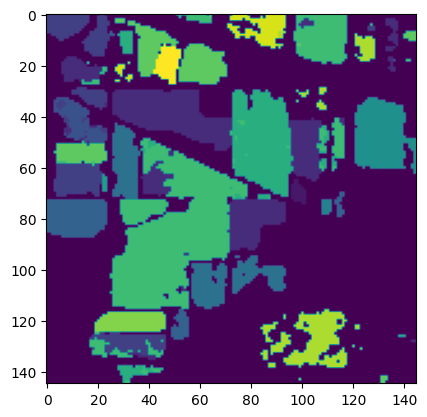

In [77]:
import cv2
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

sigmas = np.arange(0.01, 3.00, 0.01)  # different values of sigma to try
best_accuracy = 0
best_sigma = 0

# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_lda)
preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(best_image)
plt.show()